# Basic Pipeline and CNN Analysis

This is the start of the basic pipeline for reading the google quick draw training set.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_simplified.csv', 'sample_submission.csv', 'train_simplified', 'test_raw.csv']


FIrst off, lets start with trying to read a single .csv file from the dataset.

In [5]:
# Imports for data reading
import zipfile
import csv as csv
from sklearn import svm

train_airplane = pd.read_csv('../input/train_simplified/airplane.csv')
test = pd.read_csv('../input/test_simplified.csv', header=0)

print("Type of train_airplane variable: "+str(type(train_airplane))) # Should output Dataframe
print("Type of test variable: "+ str(type(test))) # Should output Dataframe

# Outputting .csv data
print(train_airplane)

# Getting train data
train_airplane.columns
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    print(train_airplane)

#test_data = test.column_name
#print(test_data)

Type of train_airplane variable: <class 'pandas.core.frame.DataFrame'>
Type of test variable: <class 'pandas.core.frame.DataFrame'>
       countrycode    ...         word
0               US    ...     airplane
1               CA    ...     airplane
2               US    ...     airplane
3               US    ...     airplane
4               IL    ...     airplane
5               US    ...     airplane
6               CZ    ...     airplane
7               AU    ...     airplane
8               MY    ...     airplane
9               BR    ...     airplane
10              US    ...     airplane
11              AU    ...     airplane
12              US    ...     airplane
13              US    ...     airplane
14              US    ...     airplane
15              GB    ...     airplane
16              US    ...     airplane
17              RU    ...     airplane
18              SK    ...     airplane
19              DE    ...     airplane
20              US    ...     airplane
21        

We can see that there are 3 fields of interest: countrycode, drawing and word.

Drawings in each country should be compared with eachother. "Drawings" are the equivalent input tensors (same as PIL) to CNN and will produce an output (confidence score that it is a certain label, e.g in this case "airplane").

# Plotting sample data
Using matplot.lib, we will print some sample data given the same training data context (airplane)

['[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, 30, 6, 1, 2, 66, 98, 253, 254, 246, 182, 165], [140, 194, 227, 232, 229, 229, 206, 124, 123, 149, 157, 159, 153, 110, 82, 77, 74, 109, 121, 127, 120]], [[207, 207, 210, 221, 238], [74, 103, 114, 128, 135]], [[119, 107, 76, 70, 49, 39, 60, 93], [72, 41, 3, 0, 1, 5, 38, 70]]]']
<class 'numpy.ndarray'>


"for i in range(12):\n    plt.subplot(2,6,i+1)\n    plt.imshow(train_airplane_npa[i])\n    plt.axis('off')\nplt.show()"

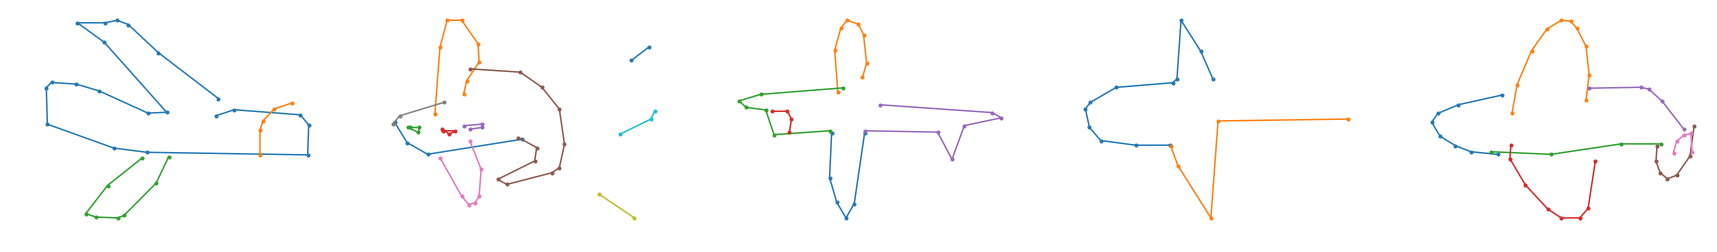

In [6]:
import ast
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image

train_airplane_npa = train_airplane[0:1].drawing.values
print(train_airplane_npa)
print(type(train_airplane_npa))
#train_airplane_images = Image.fromarray(train_airplane_npa.astype('uint8'), 'RGB')

#just_to_show_that_matplotlib_can_plot = np.array([[3, 2],[1, 3]], dtype=int)
#plt.imshow(just_to_show_that_matplotlib_can_plot)

# Prints 5 airplanes
# Change the value of index to see a different airplane image
# index = 0
fig = plt.figure()
#fig.set_figheight(fig.get_figheight()*9)
fig.set_figwidth(fig.get_figwidth()*5)
ax = fig.subplots(1, 5)
airplane_drawings = [ast.literal_eval(pts) for pts in train_airplane[0:5]["drawing"].values] #[index])
for i, airplane_drawing in enumerate(airplane_drawings):
    for x,y in airplane_drawing:
        ax[i].plot(x, y, marker='.')
        ax[i].axis('off')
    
canvas = FigureCanvas(fig)

canvas.draw()
#width, height = fig.get_size_inches() * fig.get_dpi() 
#image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
#image = image.reshape(int(height), int(width), 3)
#ax.imshow(image)

# plt.subplot(2,6,0)
# The error is probably because it is loading all rows (either that or 3d tensors don't work)
#plt.imshow(train_airplane_npa)

#plt.plot(train_airplane_npa[0])
#plt.show()

# print(train_airplane_npa)
"""for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(train_airplane_npa[i])
    plt.axis('off')
plt.show()"""

## Drawings
Each drawing is a 3d tensor that represents a series of points that can be plotted on a graph.

Consider a random airplane "drawing":
[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, 30, 6, 1, 2, 66, 98, 253, 254, 246, 182, 165], [140, 194, 227, 232, 229, 229, 206, 124, 123, 149, 157, 159, 153, 110, 82, 77, 74, 109, 121, 127, 120]], [[207, 207, 210, 221, 238], [74, 103, 114, 128, 135]], [[119, 107, 76, 70, 49, 39, 60, 93], [72, 41, 3, 0, 1, 5, 38, 70]]]

**The first subdivision splits the plots into lines.**

Line 1:
[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, 30, 6, 1, 2, 66, 98, 253, 254, 246, 182, 165], [140, 194, 227, 232, 229, 229, 206, 124, 123, 149, 157, 159, 153, 110, 82, 77, 74, 109, 121, 127, 120]]

Line 2: 
[[207, 207, 210, 221, 238], [74, 103, 114, 128, 135]]

Line 3:
[[119, 107, 76, 70, 49, 39, 60, 93], [72, 41, 3, 0, 1, 5, 38, 70]]

**For each line, the tensors correspond with eachother to form points.**

E.g for line 2:
[[207, 207, 210, 221, 238], [74, 103, 114, 128, 135]] corresponds to the points:
(207, 74), (207, 103), (210, 114), (221, 128), (238, 135)


# CNN Model


# Creating the Sample submission file
To create the sample submission file and finish the pipeline, we will create a dataframe and convert it into a .csv file.

This file should contain 112200 rows of [key_id, word] pairs.

In [ ]:
test.to_csv('submission.csv', index=False)